# Mash Distances

Plot just the mash distances and associated data from the Adelaide and Worldwide samples. This is extracted from the Data Exploring Workbook

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from matplotlib.collections import PatchCollection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import json
from natsort import natsorted

# Read the mash distances

Note that these mash distances have been filtered to exclude 16S libraries and (most) fecal metagenomes.

In [2]:
msh = pd.read_csv("OtherSequences/AdelaideWorldWide2025_distances_pairwise_selected_reduced.tsv.gz", compression='gzip', delimiter="\t", )
msh

,From,To,Distance
0,1068841_20180306_S,1068841_20180306_S,0.000000
1,1112926_20171212_S,1068841_20180306_S,0.077463
2,1128691_20171206_S,1068841_20180306_S,0.167688
3,1128691_20171218_S,1068841_20180306_S,0.161822
4,1128691_20180116_S,1068841_20180306_S,0.219531
...,...,...,...
5963359,SRR8834186,SRR8834190,0.072306
5963360,SRR8834187,SRR8834190,0.154223
5963361,SRR8834188,SRR8834190,0.103740
5963362,SRR8834189,SRR8834190,0.051530


## Create an initial heatmap.

We pivot this long format table to a wide format for the pivot

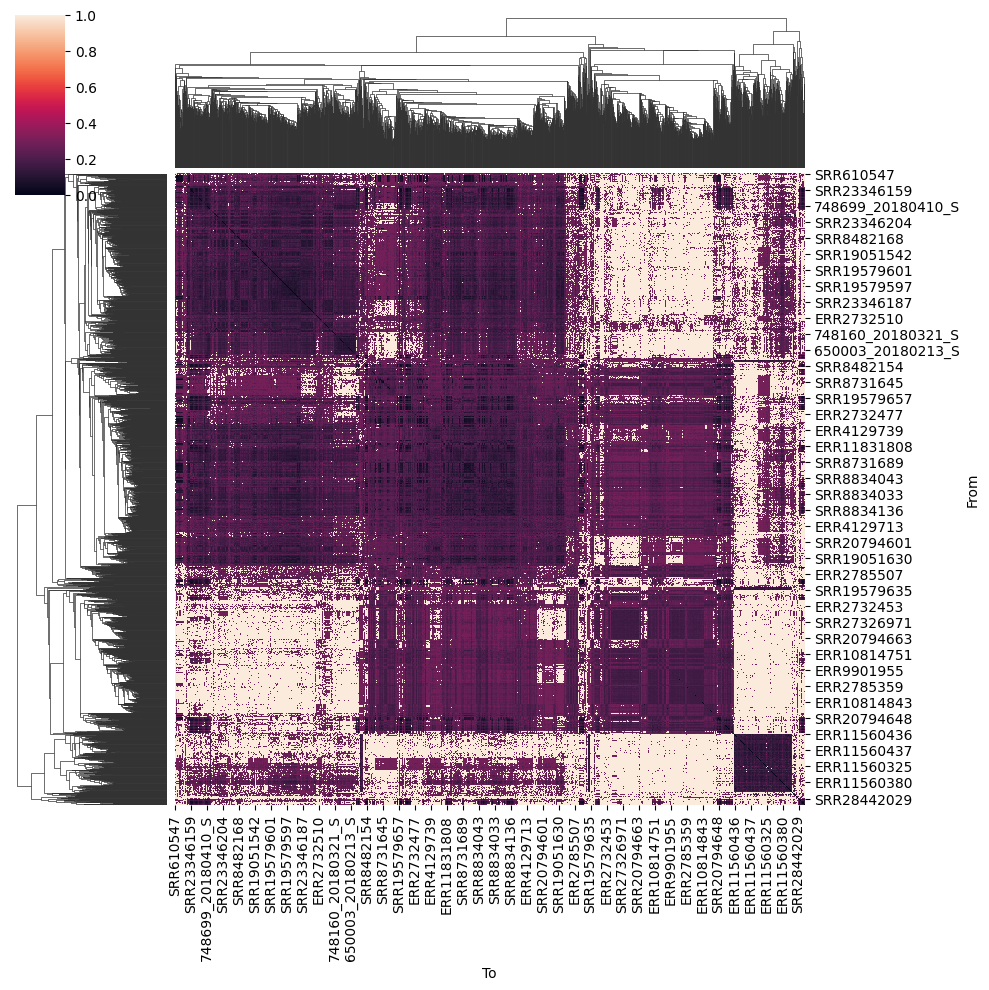

In [3]:
mshp = pd.pivot(msh, index="From", columns="To", values='Distance')
sns.clustermap(mshp)

## read the geolocation data

In [4]:
wmd = pd.read_csv("OtherSequences/bigquery.tsv.gz", compression='gzip', delimiter="\t")
locs = wmd[['Accession', 'geo_loc_name_country_calc']]
locs = locs.set_index("Accession")
locs = locs.rename(columns={'geo_loc_name_country_calc': 'Country'})
locs = locs.fillna("Unknown")

with open("Adelaide/Adelaide_samples.txt", 'r') as f:
    adl = f.read().splitlines()
tmpdf = pd.DataFrame({'Country': 'Adelaide'}, index=adl)
locs = pd.concat([tmpdf, locs])
locs['Country'] = locs['Country'].replace('uncalculated', 'Unknown')
locs

,Country
1068841_20180306_S,Adelaide
1112926_20171212_S,Adelaide
1128691_20171206_S,Adelaide
1128691_20171218_S,Adelaide
1128691_20180116_S,Adelaide
...,...
SRR9701186,Australia
SRR9701187,Australia
SRR9701188,Australia
SRR9701189,Australia


# Now read the sample data and do something similar

In [5]:
# read the material data
corrections = {
    'nasal_lavage' : 'Nasal lavage',
    'throat_swab' : 'Throat swab',
    'nasal lavage' : 'Nasal lavage',
    'throat swab' : 'Throat swab',
    'stool' : 'Stool',
    'sputum' : 'Sputum'
}

material = pd.read_csv('OtherSequences/material.tsv.gz', sep="\t", compression='gzip')
material = material.set_index('Accession')
material = material.rename(columns={'environment__material__sam': 'Material'})
for c in corrections:
    material['Material'] = material['Material'].replace(c, corrections[c])


# create a temp df with Adelaide data, and set the BAL samples appropriately.
tmpdf = pd.DataFrame({'Material': 'Sputum'}, index=adl)
for i in tmpdf.index:
    if 'BAL' in i:
        tmpdf.loc[i]['Material'] = 'Broncheolar lavage'

material = pd.concat([tmpdf, material])


# Add the unknown samples
for c in msh.From:
    if c not in material.index:
        material.loc[c, 'Material'] = 'Unknown'
        
material

,Material
1068841_20180306_S,Sputum
1112926_20171212_S,Sputum
1128691_20171206_S,Sputum
1128691_20171218_S,Sputum
1128691_20180116_S,Sputum
...,...
SRR8834187,Stool
SRR8834188,Stool
SRR8834189,Stool
SRR8834190,Stool


## Add country and sample data 

This adds both country and material data, however we may not have all the material data. 

In [6]:
print(f"msh: {msh.shape} locs: {locs.shape}")
msf = msh.join(locs, on="From", how="inner")
msf = msf.rename(columns={"Country": "From Country"})
msf = msf.join(material, on="From", how="left")
msf['Material'] = msf['Material'].fillna("Unknown")
msf = msf.rename(columns={'Material': "From Material"})
print(f"msf: {msf.shape} locs: {locs.shape}")
mst = msf.join(locs, on="To", how="inner")
mst = mst.rename(columns={"Country": "To Country"})
mst = mst.join(material, on="To", how="left")
mst['Material'] = mst['Material'].fillna("Unknown")
mst = mst.rename(columns={'Material': "To Material"})
print(f"mst: {mst.shape} locs: {locs.shape}")


msh: (5963364, 3) locs: (4135, 1)
msf: (4327224, 5) locs: (4135, 1)
mst: (3139984, 7) locs: (4135, 1)


In [7]:
mst[(mst['From'] == 'ERR10814810') | (mst['To'] == 'ERR10814810')]

,From,To,Distance,From Country,From Material,To Country,To Material
204,ERR10814810,1068841_20180306_S,1.000000,Germany,Nasal lavage,Adelaide,Sputum
2646,ERR10814810,1112926_20171212_S,1.000000,Germany,Nasal lavage,Adelaide,Sputum
5088,ERR10814810,1128691_20171206_S,1.000000,Germany,Nasal lavage,Adelaide,Sputum
7530,ERR10814810,1128691_20171218_S,1.000000,Germany,Nasal lavage,Adelaide,Sputum
9972,ERR10814810,1128691_20180116_S,1.000000,Germany,Nasal lavage,Adelaide,Sputum
...,...,...,...,...,...,...,...
5951358,ERR10814810,SRR8834186,0.243761,Germany,Nasal lavage,Unknown,Stool
5953800,ERR10814810,SRR8834187,0.197292,Germany,Nasal lavage,Unknown,Stool
5956242,ERR10814810,SRR8834188,0.164662,Germany,Nasal lavage,Unknown,Stool
5958684,ERR10814810,SRR8834189,0.243761,Germany,Nasal lavage,Unknown,Stool


# pivot the table

Now that we have our long form table with both country and sample material merged, we need to pviot this again so we can make a heatmap.

In [9]:
mstp = mst.pivot(index="From", columns="To", values="Distance")
mstp

To,1068841_20180306_S,1112926_20171212_S,1128691_20171206_S,1128691_20171218_S,1128691_20180116_S,1162967_20180116_S,1255498_20171212_S,1282052_20180206_S,1316935_20180417_S,1316979_20171215_S,...,SRR8834181,SRR8834182,SRR8834183,SRR8834184,SRR8834185,SRR8834186,SRR8834187,SRR8834188,SRR8834189,SRR8834190
From,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0.000000,0.077463,0.167688,0.161822,0.219531,0.149777,0.088783,0.113823,0.088264,0.094378,...,0.230110,0.197292,0.197292,0.178173,0.203604,0.159146,0.295981,0.295981,0.191731,0.161822
1112926_20171212_S,0.077463,0.000000,0.111073,0.114780,0.133864,0.104495,0.081179,0.072306,0.083404,0.088264,...,0.159146,0.161822,0.156619,0.151946,0.170926,0.135380,0.243761,0.263022,0.164662,0.161822
1128691_20171206_S,0.167688,0.111073,0.000000,0.051920,0.051725,0.063168,0.136948,0.106047,0.130979,0.164662,...,0.070620,0.142009,0.149777,0.136948,0.111073,0.128270,0.243761,0.263022,0.147707,0.136948
1128691_20171218_S,0.161822,0.114780,0.051920,0.000000,0.054997,0.066265,0.135380,0.100846,0.125715,0.143830,...,0.069323,0.135380,0.128270,0.117785,0.110193,0.121010,0.219531,0.210897,0.123300,0.133864
1128691_20180116_S,0.219531,0.133864,0.051725,0.054997,0.000000,0.063987,0.219531,0.115759,0.138572,0.210897,...,0.060565,0.123300,0.142009,0.125715,0.101551,0.191731,1.000000,1.000000,0.182269,0.210897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR8834186,0.159146,0.135380,0.128270,0.121010,0.191731,0.103740,0.124491,0.138572,0.121010,0.161822,...,0.170926,0.138572,0.126974,0.122140,0.135380,0.000000,0.145727,0.116760,0.070951,0.072306
SRR8834187,0.295981,0.243761,0.243761,0.219531,1.000000,0.219531,0.230110,0.263022,0.230110,0.263022,...,0.115759,0.145727,0.145727,0.124491,0.108487,0.145727,0.000000,0.105264,0.126974,0.154223
SRR8834188,0.295981,0.263022,0.263022,0.210897,1.000000,0.178173,0.210897,0.243761,0.263022,0.295981,...,0.126974,0.149777,0.138572,0.126974,0.123300,0.116760,0.105264,0.000000,0.096215,0.103740


### set some color palettes for the countries and materials

In [10]:
palette = sns.color_palette("Set1", 9)

clut = dict(zip(mst['From Country'].unique(), palette))
clut['Unknown'] = (1,1,1)
rc = locs.loc[mstp.index]['Country'].map(clut)

mlut = dict(zip(mst['From Material'].unique(), palette))
mlut['Unknown'] = (1,1,1)
cc = material.loc[mstp.columns]['Material'].map(mlut)


### Plot the heatmap

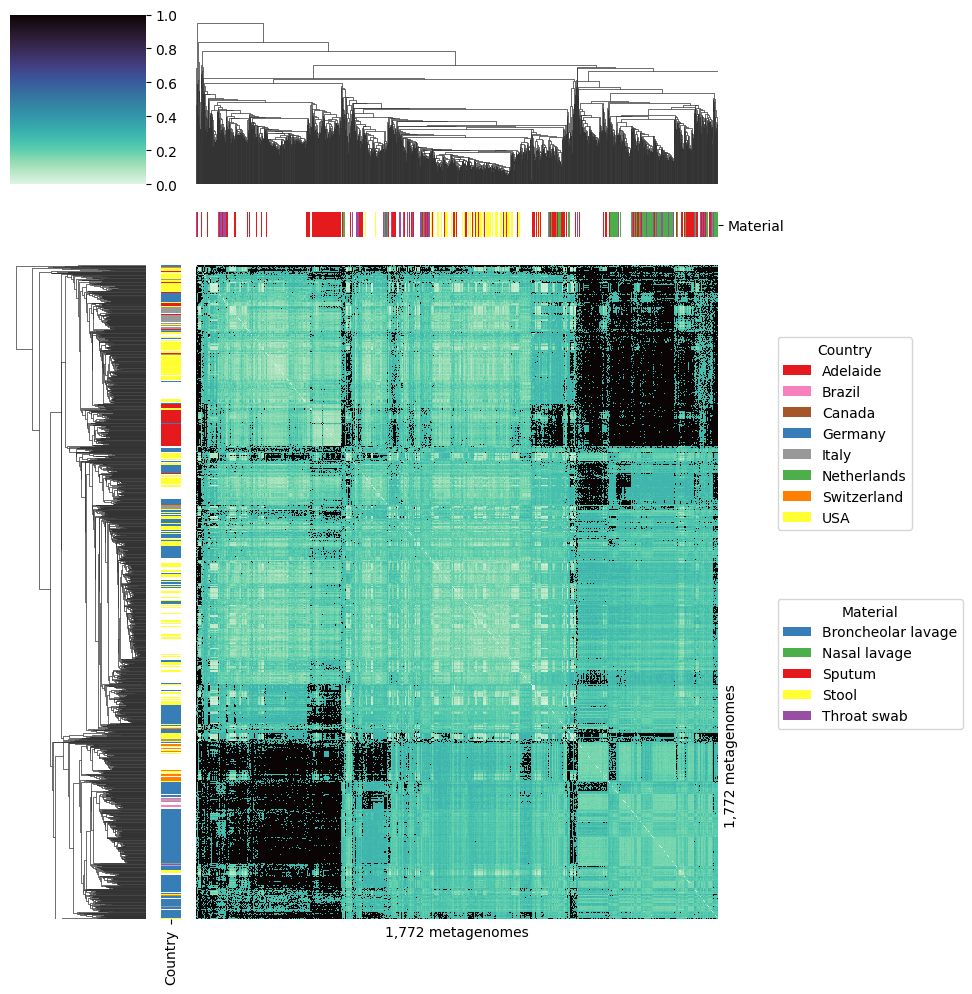

In [11]:
cg = sns.clustermap(mstp,
                   row_cluster=True, col_cluster=True, 
                   row_colors=rc, col_colors=cc,
                   yticklabels=False,xticklabels=False,
                   cmap="mako_r")
ax = cg.ax_heatmap
ax.set_ylabel(f"{mstp.shape[0]:,} metagenomes")
ax.set_xlabel(f"{mstp.shape[0]:,} metagenomes")

ax.yaxis.set_label_coords(1.01, 0.25)

row_names = [name for name in sorted(clut, key=str.casefold) if 'Unknown' not in name]
col_names = [name for name in sorted(mlut, key=str.casefold) if 'Unknown' not in name]


# Create legend handles for the row colors.
row_handles = [Patch(facecolor=clut[name]) for name in row_names]

col_handles = [Patch(facecolor=mlut[name]) for name in col_names]

# Add the first legend (e.g., for row colors)
leg1 = ax.legend(row_handles, row_names, title="Country", loc='upper left', 
                            bbox_to_anchor=(1.1, 0.9))
ax.add_artist(leg1)  # Add it manually so it isn't overwritten

# Add the second legend (for column colors) below the first one
leg2 = ax.legend(col_handles, col_names, title="Material", loc='upper left', 
                            bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
#cg.savefig("mash_distances.png")
plt.show()